# データフレーム作成

In [1]:
# ライブラリ
import numpy as np
import pandas as pd
from datetime import datetime

In [86]:
# そのままだと読み込んでくれないので、読み込むカラム名を指定する必要がある
days = "231010_MN230704"
columns_name = ["名前", "硬さ_試験力", "エネルギー(絶対値)_1", "エネルギー(絶対値)_2", "凸点最大2_ストローク",
                "凸点最大1_試験力", "凹点最小1_試験力", "破断点_試験力", "もろさ", "付着性", "付着力_試験力",
                "弾性率_Standard", "弾性率_Chord", "弾性率_Secant", "弾性率_Tangent", "弾性率_最大傾き",
                "弾力性", "凝縮性", "ガム性", "そしゃく性"]
df = pd.read_csv(f"../Texture/experiment/{days}_output.csv", encoding="SHIFT-JIS", names=columns_name, skiprows=17)
display(df)

,名前,硬さ_試験力,エネルギー(絶対値)_1,エネルギー(絶対値)_2,凸点最大2_ストローク,凸点最大1_試験力,凹点最小1_試験力,破断点_試験力,もろさ,付着性,付着力_試験力,弾性率_Standard,弾性率_Chord,弾性率_Secant,弾性率_Tangent,弾性率_最大傾き,弾力性,凝縮性,ガム性,そしゃく性
0,1 _ 1,23.00140,0.16105,0.04479,8.75025,23.00140,22.3914,21.6895,0.61003,0.00000,-0.05970,0.43788,0.44630,0.43831,0.63995,17.69000,0.42343,0.27813,6.39728,2.70882
1,1 _ 2,22.84280,0.15521,0.03177,8.75038,22.84280,20.8809,20.0774,1.96195,-0.00020,-0.18030,0.40396,0.40441,0.42795,0.44142,0.47274,0.62032,0.20470,4.67593,2.90057
2,1 _ 3,30.91840,0.21662,0.05331,8.75100,30.91840,28.8861,29.4826,2.03228,-0.00030,-0.29000,0.63294,0.64209,0.66866,0.88028,0.89386,0.77770,0.24610,7.60892,5.91745
3,1 _ 4,27.66560,0.18855,0.04371,8.75088,27.66560,24.8099,26.1519,2.85570,-0.00020,-0.16980,0.56926,0.57253,0.54969,0.67402,0.69322,0.76667,0.23181,6.41325,4.91682
4,1 _ 5,25.66980,0.17191,0.03659,8.75113,25.66980,-.-,20.6573,-.-,-0.00010,-0.08710,0.53697,0.53691,0.48557,0.62943,0.66241,0.63741,0.21283,5.46320,3.48229
5,1 _ 6,31.81940,0.19961,0.07094,8.75013,31.81940,-.-,29.9789,-.-,-0.00030,-0.47190,0.58850,0.57875,0.46921,0.57639,32.87380,0.48511,0.35537,11.30770,5.48553
6,平均値,26.98620,0.18216,0.04685,8.75063,26.98620,24.2421,24.6729,1.86499,-0.00020,-0.20980,0.52825,0.53017,0.50657,0.64025,8.88101,0.61844,0.25482,6.97771,4.23525
7,標準偏差,3.84871,0.02371,0.01392,0.00043,3.84871,2.70599,4.4636,0.92984,0.00012,0.15178,0.08940,0.08897,0.09034,0.14317,13.58180,0.14388,0.05574,2.34071,1.38100
8,レンジ値,8.97660,0.06141,0.03917,0.00100,8.97660,8.00520,9.9015,2.24567,0.00030,0.41220,0.22898,0.23768,0.24071,0.43886,32.40110,0.35427,0.15067,6.63177,3.20863


In [87]:
# csv作成にあたり不要なカラムを削除
df_csv = df.drop(columns=["エネルギー(絶対値)_1", "エネルギー(絶対値)_2", "凸点最大2_ストローク", "凸点最大1_試験力", "凹点最小1_試験力", "破断点_試験力", "付着性"])

# 欠損値をNaNに変換する
df_csv = df_csv.replace("-.-", np.nan)

# 外れ値の範囲を算出
Q1 = df_csv.iloc[0:6].quantile(0.25) # 第一四分位数
Q3 = df_csv.iloc[0:6].quantile(0.75) #  第三四分位数
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# もろさを一旦格納
brittleness = df_csv["もろさ"].copy()

# 外れ値除去
for i in range(len(lower_bound)):
    # 外れ値除去を行うカラムを指定
    column = lower_bound.index[i]
    # 範囲外の値をNaNに変換
    df_csv.loc[0:5,column] = df_csv.loc[0:5,column].apply(lambda x: np.nan if x < lower_bound[i] or x > upper_bound[i] else x)

# もろさだけもとに戻す（外れ値除去から外す）
df_csv["もろさ"] = brittleness
    
# もろさの有無を特徴量に変換（もろさなし=0、もろさあり=1）
df_csv["もろさ有無"] = 1 - df_csv["もろさ"].isnull().astype(int)

# 熟成日数の計算
dt1 = datetime(year=int(str(20)+days[9:11]), month=int(days[11:13]), day=int(days[13:15]))
dt2 = datetime(year=int(str(20)+days[:2]), month=int(days[2:4]), day=int(days[4:6]))
dt3 = dt2- dt1
df_csv["熟成日数"] = int(dt3.days)

# 表示とcsv出力
#df_csv = df_csv.drop(columns=["弾性率_Chord", "弾性率_Secant", "弾性率_Tangent", "弾性率_最大傾き"])
display(df_csv)
df_csv.to_csv(f"../Texture/output/{days}_texture.csv", index=False)

,名前,硬さ_試験力,もろさ,付着力_試験力,弾性率_Standard,弾性率_Chord,弾性率_Secant,弾性率_Tangent,弾性率_最大傾き,弾力性,凝縮性,ガム性,そしゃく性,もろさ有無,熟成日数
0,1 _ 1,23.00140,0.61003,-0.05970,0.43788,0.44630,0.43831,0.63995,17.69000,0.42343,0.27813,6.39728,2.70882,1,98
1,1 _ 2,22.84280,1.96195,-0.18030,0.40396,0.40441,0.42795,NaN,0.47274,0.62032,0.20470,4.67593,2.90057,1,98
2,1 _ 3,30.91840,2.03228,-0.29000,0.63294,0.64209,NaN,NaN,0.89386,0.77770,0.24610,7.60892,5.91745,1,98
3,1 _ 4,27.66560,2.85570,-0.16980,0.56926,0.57253,0.54969,0.67402,0.69322,0.76667,0.23181,6.41325,4.91682,1,98
4,1 _ 5,25.66980,NaN,-0.08710,0.53697,0.53691,0.48557,0.62943,0.66241,0.63741,0.21283,5.46320,3.48229,0,98
5,1 _ 6,31.81940,NaN,-0.47190,0.58850,0.57875,0.46921,0.57639,NaN,0.48511,NaN,NaN,5.48553,0,98
6,平均値,26.98620,1.86499,-0.20980,0.52825,0.53017,0.50657,0.64025,8.88101,0.61844,0.25482,6.97771,4.23525,1,98
7,標準偏差,3.84871,0.92984,0.15178,0.08940,0.08897,0.09034,0.14317,13.58180,0.14388,0.05574,2.34071,1.38100,1,98
8,レンジ値,8.97660,2.24567,0.41220,0.22898,0.23768,0.24071,0.43886,32.40110,0.35427,0.15067,6.63177,3.20863,1,98


# プロファイル描画

In [88]:
# ライブラリ
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import itertools # Textureのdfのカラムfor文で一次元化するのに必要
sns.set(style="whitegrid", font=["Meiryo", "Yu Gothic", "Hiragino Maru Gothic Pro"])

# グラフデフォルトパラメータ
#plt.rcParams["font.family"] = "Times New Roman" # font familyの設定 英語論文用
plt.rcParams["mathtext.fontset"] = "stix" # math fontの設定
plt.rcParams["font.size"] = 16 # 全体のフォントサイズが変更されます。
plt.rcParams["xtick.labelsize"] = 12 # 軸だけ変更されます。
plt.rcParams["ytick.labelsize"] = 12 # 軸だけ変更されます
plt.rcParams["xtick.direction"] = "in" # x axis in
plt.rcParams["ytick.direction"] = "in" # y axis in 
plt.rcParams["xtick.minor.visible"] = False # x軸補助目盛りの追加
plt.rcParams["ytick.minor.visible"] = False # y軸補助目盛りの追加
plt.rcParams["axes.grid"] = False # make grid
plt.rcParams["legend.fancybox"] = False # 丸角
plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = "black"

In [89]:
# 日数を指定
days = ["230608_MN230214", 
        "230615_MN230606",
        "230616_MN221005", 
        "230619_MN220907", 
        "230622_MN230606",
        "230627_MN230214",
        "230703_MN230606", 
        "230715_MN230606", 
        "230725_MN230606", 
        "230809_MN230606", 
        "230914_MN230704",
        "230925_MN230704", 
        "230927_MN230214", 
        "231010_MN230214", 
        "231010_MN230704", 
        "231019_MN230704"
       ]

# 色指定
color_list = []
file_num = len(days)
for i in range(0, file_num):
    color_list.append(cm.gist_rainbow((i+1)/file_num))

# 熟成日数の計算
label_days = []
for day in days:
    dt1 = datetime(year=int(str(20)+day[9:11]), month=int(day[11:13]), day=int(day[13:15]))
    dt2 = datetime(year=int(str(20)+day[:2]), month=int(day[2:4]), day=int(day[4:6]))
    dt3 = dt2- dt1
    label_days.append(int(dt3.days))
    
# 熟成日数順のindexを取得
label_days_idx = np.argsort(label_days)
label_days = np.sort(label_days)

#  熟成日数順にdaysを並び替える
days = np.array(days)[label_days_idx].tolist()

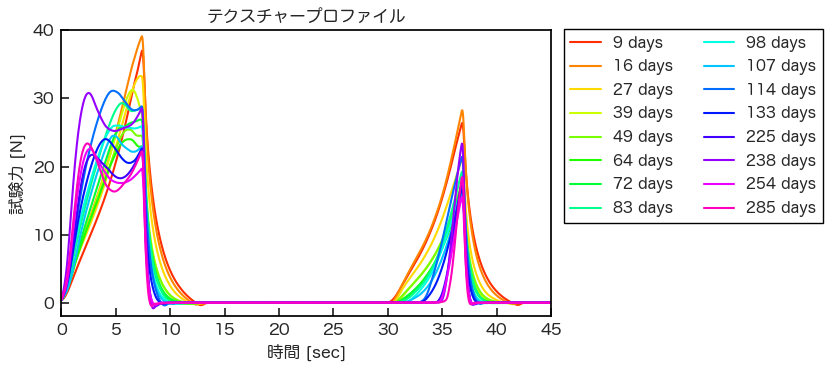

In [90]:
# カラム名の作成
columns_name = []
for i in range(1, 7):
        columns_name.append(["Time1_{}[sec]".format(i), "Force1_{}[N]".format(i), "Stroke1_{}[mm]".format(i)])
columns_name = list(itertools.chain.from_iterable(columns_name))

# 読み込んだdfを保存するためのリストを作成
df_time = []
df_force = []
df_stroke = []
df_time_mean = []
df_force_mean = []
df_stroke_mean = []

# 読み込み
for day in days:
    df_texture = pd.read_csv(f"../Texture/experiment/{day}.csv", encoding="SHIFT-JIS", skiprows=3, header=None, dtype=float, names=columns_name)
    # 時間、力、ストロークごとに抽出
    time =df_texture.iloc[:,[i for i in range(0,18,3)]]
    force = df_texture.iloc[:,[i for i in range(1,18,3)]]
    stroke = df_texture.iloc[:,[i for i in range(2,18,3)]]

    # 平均計算
    time_mean = time.mean(axis='columns')
    force_mean = force.mean(axis='columns')
    stroke_mean = stroke.mean(axis='columns')

    # listに保存
    df_time.append(time)
    df_force.append(force)
    df_stroke.append(stroke)
    df_time_mean.append(time_mean)
    df_force_mean.append(force_mean)
    df_stroke_mean.append(stroke_mean)
    
# テクスチャープロファイル作成
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(len(days)):
    # 全てプロット
    # ax.plot(df_time[i].iloc[0], df_force[i].iloc[0], label=str(label_days[i])+" days", color=color_list[i])
    # ax.plot(df_time[i].iloc[1:], df_force[i].iloc[1:], color=color_list[i])
    # 平均のみをプロット
    ax.plot(df_time_mean[i], df_force_mean[i], label=str(label_days[i])+" days", color=color_list[i])

ax.set_xlabel("時間 [sec]")
ax.set_ylabel("試験力 [N]")
ax.set_title("テクスチャープロファイル")
ax.set_xlim(0, 45)
ax.set_ylim(-2, 40)
ax.spines["top"].set_color("black")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.spines["right"].set_color("black")
ax.tick_params(pad=5)
plt.tick_params(bottom=True, left=True, right=False, top=False)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.57, 1.03), loc="upper right", ncol=2)
plt.savefig("../Plot/テクスチャープロファイル.png", dpi=500, bbox_inches='tight')
plt.show()